# Tutorial for regression benchmarking

This code loads data and a design matrix, then benchmarks methods of ridge regression in terms of accuracy and speed, both for estimating the alpha(s) and for performing the cross-validated prediction.

Written by Michael Sokoletsky, 2023.


### Imports and opts

In [80]:
import time
import itertools 

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import  GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score
from scipy.optimize import fminbound
from tqdm.notebook import tqdm

import regbench as rb
opts = {}
# Recording parameters
opts['local_disk'] = 'D:\Churchland\Widefield'
opts['rec_name'] = 'mSM63_09-Aug-2018' # Recording name
opts['frames_per_trial'] = 75 # Num of frames per trial
opts['dformat'] = 'MATLAB'
# Regbench parameters
opts['out_folds'] = 10 # Num of folds for outer (test) cross-validation
opts['in_folds'] = 5 # Num of folds for inner (train) cross-validation
opts['alpha_mets'] = ['Karabastos', 'GridSearchCV', 'fminbound', 'None'] # Alpha estimation methods to test
opts['crossval_mets'] = ['Kaufman', 'Ridge', 'cross_val_predict'] # Cross-validation methods to test
opts['test_range'] =  np.concatenate([np.arange(1, 2000, 500),
                                      np.arange(3000, 13000,2000),
                                      np.arange(15000, 30000, 5000)]) # Range to test in cross-validated alpha estimation methods
opts['n_jobs'] = -1 # Num of concurrently running workers in cross-validated alpha estimation methods. -1 uses the full CPU capacity.
opts['scoring'] = 'r2' # Method of scoring in cross-validated alpha estimation methods
opts['xtol'] = 100 # Convergence tolerance for the fminbound alpha estimation method

### Load data and design matrix

In [81]:
data = rb.load_data(opts) # Load widefield data
design = rb.load_design(opts) # Load design DataFrame
design_norm = (design-design.mean())/design.std() # Normalize design DataFrrame
out_split, in_split = rb.split_by_trials(data, opts) # Split data into outer and inner folds by trials

### Benchmark methods of estimating alphas

In [82]:
alphas = {}
alpha_times = {}
train_idx, _ = out_split[0]
for alpha_method in tqdm(opts['alpha_mets'], desc='Alpha method num'):
    st = time.time()
    if alpha_method == 'Karabastos':
        alphas[alpha_method] = rb.ridge_MML(data.svt[train_idx, :], design_norm.loc[train_idx], regress=False)
    elif alpha_method == 'GridSearchCV':
        mdl = GridSearchCV(Ridge(), {'alpha': opts['test_range']}, cv=in_split, scoring=opts['scoring'], n_jobs=opts['n_jobs'], refit=False)
        mdl.fit(design_norm.loc[train_idx], data.svt[train_idx, :])
        alphas[alpha_method] = mdl.best_params_['alpha']
        mdl.best_params_['alpha']
    elif alpha_method == 'fminbound':
        score_func = rb.mint_score_func(design_norm.loc[train_idx], data.svt[train_idx, :], cv=in_split, scoring=opts['scoring'] , n_jobs=opts['n_jobs'])
        alphas[alpha_method] = fminbound(score_func, opts['test_range'][0], opts['test_range'][-1], xtol=opts['xtol'])
    elif alpha_method == 'None':
        alphas[alpha_method] = 0
    alpha_times[alpha_method] = time.time() - st

Alpha method num:   0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\michaeso.WISMAIN\OneDrive - weizmann.ac.il\Research\Analysis 2.0\regbench-main\regbench\ridge.py:319: RuntimeWarning: divide by zero encountered in log
  NLL_func = lambda L: - (q * np.log(L) - np.sum(np.log(L + d2[:q])) \


### Benchmark methods of cross-validation

In [83]:
preds = {(opt1, opt2): np.zeros_like(data.svt) for opt1, opt2 in itertools.product(opts['crossval_mets'], opts['alpha_mets'])}
scores = {}
pred_times = {}
for crossval_method in tqdm(opts['crossval_mets'], desc='Crossval method num'):
    for alpha_method in tqdm(opts['alpha_mets'], desc='Alpha method num'):
        st = time.time()
        if crossval_method == 'Kaufman':
            for (train_idx, test_idx) in out_split:
                c_beta = rb.ridge_MML(data.svt[train_idx, :], design_norm.loc[train_idx], L=alphas[alpha_method])
                preds[crossval_method, alpha_method][test_idx, :] = design_norm.loc[test_idx] @ c_beta
        elif crossval_method == 'Ridge':
            mdl = Ridge(alpha=alphas[alpha_method])
            for (train_idx, test_idx) in out_split:
                mdl.fit(design_norm.loc[train_idx], data.svt[train_idx, :])
                preds[crossval_method, alpha_method][test_idx, :] = mdl.predict(design_norm.loc[test_idx])
        elif crossval_method == 'cross_val_predict':
            mdl = Ridge(alpha=alphas[alpha_method])
            preds[crossval_method, alpha_method] = cross_val_predict(mdl, design_norm, data.svt, cv=out_split, n_jobs=opts['n_jobs'])
        scores[crossval_method, alpha_method] = r2_score(data.svt, preds[crossval_method, alpha_method])
        pred_times[crossval_method, alpha_method] = time.time() - st + alpha_times[alpha_method]

rb.save_results({'alphas': alphas,
                 'preds': preds,
                 'scores': scores,
                 'alpha_times': alpha_times,
                 'pred_times': pred_times}, opts)  # Save results

Crossval method num:   0%|          | 0/3 [00:00<?, ?it/s]

Alpha method num:   0%|          | 0/4 [00:00<?, ?it/s]

Alpha method num:   0%|          | 0/4 [00:00<?, ?it/s]

Alpha method num:   0%|          | 0/4 [00:00<?, ?it/s]

### Benchmarking summary plots

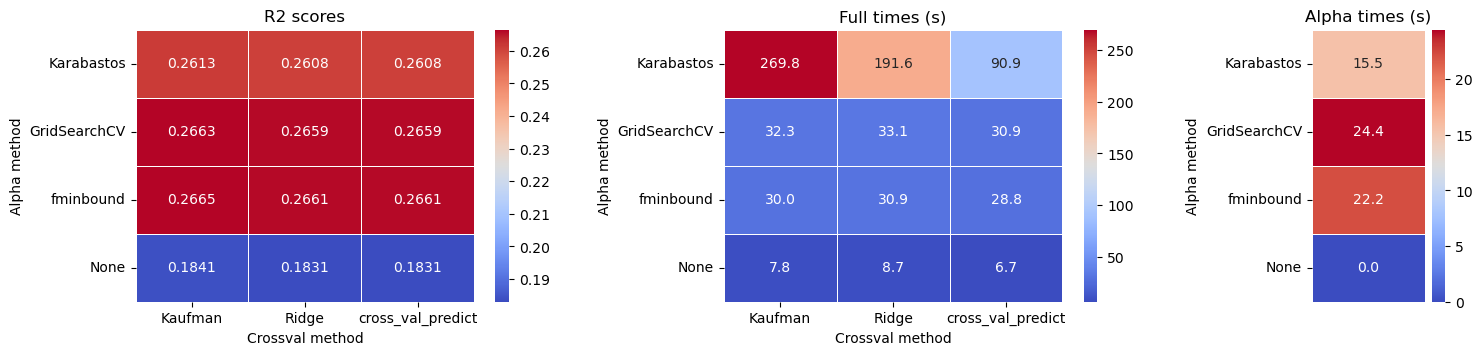

In [84]:
sum_fig, sum_ax = plt.subplots(ncols=3, gridspec_kw={'width_ratios': [3, 3, 1]}, figsize=(17,4))

scores_df = rb.unstack(pd.Series(scores))
scores_plot = sns.heatmap(scores_df, annot=True, fmt='.4f', cmap="coolwarm", linewidth=.5, ax=sum_ax[0])
scores_plot.set(title='R2 scores', xlabel='Crossval method', ylabel='Alpha method')

times_df = rb.unstack(pd.Series(pred_times))
times_plot = sns.heatmap(times_df, annot=True, fmt='.1f', cmap="coolwarm", linewidth=.5, ax=sum_ax[1])
times_plot.set(title='Full times (s)', xlabel='Crossval method', ylabel='Alpha method')

alpha_times_df = pd.Series(alpha_times).to_frame();
alpha_times_plot = sns.heatmap(alpha_times_df, annot=True, fmt='.1f', cmap="coolwarm", linewidth=.5, ax=sum_ax[2], xticklabels=False)
alpha_times_plot.set(title='Alpha times (s)', ylabel='Alpha method');

plt.subplots_adjust(bottom=0.2, wspace=0.5)
rb.save_fig(sum_fig, opts, name=f'rb_results_{opts["rec_name"]}') # Save plot

### Compute correlation maps

In [88]:
corrs = {}
for nx, crossval_method in enumerate(opts['crossval_mets']):
    for ny, alpha_method in enumerate(opts['alpha_mets']):
        corrs[crossval_method, alpha_method] = rb.model_corr(data, preds[crossval_method, alpha_method])

### Plot correlation maps

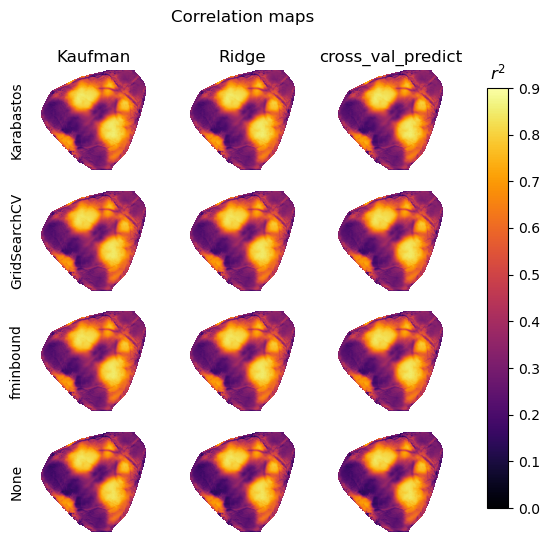

In [90]:
corr_fig, corr_ax = plt.subplots(len(opts['alpha_mets']), len(opts['crossval_mets']), figsize=(7, 6))
plt.suptitle('Correlation maps')

[axi.grid(False) for axi in corr_ax.ravel()]
[axi.spines[['bottom', 'left', 'right', 'top']].set_visible(False) for axi in corr_ax.ravel()]
[axi.set_xticks([]) for axi in corr_ax.ravel()]
[axi.set_yticks([]) for axi in corr_ax.ravel()]

plots = {}
for nx, crossval_method in enumerate(opts['crossval_mets']):
    for ny, alpha_method in enumerate(opts['alpha_mets']):
        plots[ny, nx] = corr_ax[ny, nx].imshow(corrs[crossval_method, alpha_method], cmap='inferno', vmin=0, vmax=0.9)
        if ny == 0: corr_ax[ny, nx].set_title(crossval_method)
        if nx == 0: 
            corr_ax[ny, nx].set_ylabel(alpha_method)

corr_fig.subplots_adjust(left=0.2, right=0.8)
cbar_ax = corr_fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = corr_fig.colorbar(plots[0, 0], cax=cbar_ax, orientation='vertical')
cbar_ax.set_title('$r^2$');

rb.save_fig(corr_fig, opts, name=f'rb_corrs_{opts["rec_name"]}') # Save plot